# <div align="center"><img src="https://www.icegif.com/wp-content/uploads/icegif-87.gif" width=800/></div>

## What I want to do in this notebook📙?
##### spam detection, is a formal problem that all of us saw it in ML courses intros.

##### the dataset we have contains thousands of text examples and labels(ham/spam), here goal is to create and train a model that has the best 

##### performance and can predict a text is spam or ham(not spam).

##### in this notebook I want to solve this problem in four ways:
#### `baseline_model` -> Random-Forest model to discover initial patterns(simple model)

#### `model_1` -> Custom Text Vectorization, Embedding + Dense layers

#### `model_2` -> Custom layers + Bidirectional-LSTM layers

#### `model_3` -> USE embedding layer(transfer learning) + Sequential API

In [ ]:
import numpy as np # numerical computing 
import pandas as pd # data analysis, working with DataFrames
import matplotlib.pyplot as plt # visualizations
import seaborn as sns # visulizations ++
import tensorflow as tf # our main library, deep learning modellign
from tensorflow import keras # keras library
from tensorflow.keras import layers # for creating layers

In [ ]:
df = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding="latin-1") # reading data

# Become One with the Data! 🔍

<div align="center"><img src="https://c.tenor.com/KGQ_42IC9vUAAAAC/spam-email.gif" /></div>

<div align="center"><img src="https://miro.medium.com/max/1400/0*ZzcKU607S3OWpn5I.jpg" width=800/></div>

## Why actually an Spam SMS?
>Scammers send fake text messages to trick you into giving them your personal information – things like your password, account number, or Social Security number. If they get that information, they could gain access to your email, bank, or other accounts.

https://www.consumer.ftc.gov/articles/how-recognize-and-report-spam-text-messages#:~:text=what%20to%20do.-,Spam%20Text%20Messages%20and%20Phishing,%2C%20bank%2C%20or%20other%20accounts.

# A defenition of spam detection:
> This is called Spam Detection, and it is a binary classification problem. The reason to do this is simple: by detecting unsolicited and unwanted emails, we can prevent spam messages from creeping into the user's inbox, thereby improving user experience.

https://towardsdatascience.com/spam-detection-in-emails-de0398ea3b48#:~:text=This%20is%20called%20Spam%20Detection,inbox%2C%20thereby%20improving%20user%20experience.

#### our dataset is SMS data not Email, but they are similar.

In [ ]:
df.head() # an overview 

#### this dataset has three Unnamed columns that we don't need, so we just `drop` them
#### also our label is in string form -> `spam` and `ham`, so we map them in numerical form

In [ ]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1':'label', 'v2':'Text'})
df['label_in_num'] = df['label'].map({'ham':0,'spam':1})
df.head()

### a bit Analysis!📉 

In [ ]:
sns.countplot(x=df['label']) # countplot for label

In [ ]:
df['label'].value_counts()

### Imbalanced case:
data points with ham label are 6.5 times more than points with spam labels,

so this leads to a Imbalanced dataset.

In [ ]:
sns.countplot(x=[len(df.loc[i]['Text']) for i in range(len(df))])
plt.xlabel('Text length')

### We want these things:
* number of words in the whole dataset
* mean of word count in every row
* total words in dataset

In [ ]:
text_words_lengths = [len(df.loc[i]['Text'].split()) for i in range(0, len(df))]
total_length = np.sum(text_words_lengths)
text_words_mean = int(np.mean(text_words_lengths))
print('we have ' + str(total_length) + ' words in our Dataframe')
print('the average word count in every scentence is ' + str(text_words_mean))
text_words_lengths[:5], total_length, text_words_mean

# Train-Test Split ✂, an Important Step! 

In [ ]:
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_in_num'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
len(X_train), len(X_test), X_train[:2], y_train[:2]

# Baseline Model - Random Forest 🌲

<div align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png" /></div>

#### I chose Random Forest, because it can be a good model for start. we creat our baseline and then we try to beat it.
##### `TFIDF` -> preprocessing the text data

##### `Random-Forest` -> creating machine learning model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec, X_test_vec = tfidf_vec.transform(X_train), tfidf_vec.transform(X_test)
baseline_model = RandomForestClassifier(n_estimators=250)
baseline_model.fit(X_train_vec, y_train)

random_forest_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

### Confusino matrix for baseline model

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(baseline_model, X_test_vec, y_test)

# Creating Custom Text Vectorization and Embedding layers

### <div align="center"><img src="https://www.pinecone.io/images/vector_embeddings.jpg" width=1000/></div>

### Text Vectorization:
>  Text Vectorization is the process of converting text into numerical representation. Here is some popular methods to accomplish text vectorization: Binary Term Frequency. Bag of Words (BoW) Term Frequency. (L1) Normalized Term Frequency. 

source : [towards datascience](https://towardsdatascience.com/getting-started-with-text-vectorization-2f2efbec6685#:~:text=Text%20Vectorization%20is%20the%20process,(L1)%20Normalized%20Term%20Frequency)

### Word embedding:
>  A word embedding is a learned representation for text where words that have the same meaning have a similar representation. ... Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.

source : [machine learning mastery](https://machinelearningmastery.com/what-are-word-embeddings/#:~:text=A%20word%20embedding%20is%20a,meaning%20have%20a%20similar%20representation.&text=Each%20word%20is%20mapped%20to,the%20field%20of%20deep%20learning.)

In [ ]:
MAXTOKENS = total_length
OUTPUTLEN = text_words_mean

text_vec = layers.TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)

text_vec.adapt(X_train)

In [ ]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

# Model 1 - Using our custom layers with 2 Dense layers

In [ ]:
# Input layer
input_layer = layers.Input(shape=(1,), dtype=tf.string)
# Text Vectorizatino layer
vec_layer = text_vec(input_layer)
# Embedding layer
embedding_layer_model = embedding_layer(vec_layer)
# Global Average Pooling layer
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
# Flatten layer for Dense layers
x = layers.Flatten()(x)
# 32 units dense layer
x = layers.Dense(32, activation='relu')(x)
# output layer with sigmoid activation function
output_layer = layers.Dense(1, activation='sigmoid')(x)
# final model
model_1 = keras.Model(input_layer, output_layer)

### Compile `model_1`

In [ ]:
model_1.compile(optimizer=keras.optimizers.Adam(),
               loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
               metrics=['accuracy'])

### Fit the model

In [ ]:
history_1 = model_1.fit(X_train,
           y_train,
           epochs=5,
           validation_data=(X_test, y_test),
           validation_steps=int(0.2 * len(X_test)))

In [ ]:
pd.DataFrame(history_1.history).plot()

# helper functions 🛠 

##### compile_model(), fit_model(), evaluate_model():
##### I want to compile, fit and evaluate for a few models, so I just creat method to easily reuse the code over and over.

In [ ]:
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])    

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train and test data
    '''
    history = model.fit(X_train,
              y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
             validation_steps=int(0.2*len(X_test)))
    return history
 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    
    model_results_dict = {'accuracy':accuracy,
                         'precision':precision,
                         'recall':recall,
                         'f1-score':f1}
    
    return model_results_dict

# Model 2 - Bidirectional LSTM 

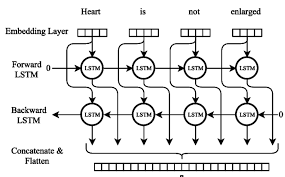

***A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).***

https://paperswithcode.com/method/bilstm#:~:text=A%20Bidirectional%20LSTM%2C%20or%20biLSTM,other%20in%20a%20backwards%20direction.

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string) # Input layer, string type(text)
vec_layer = text_vec(input_layer) # text vectorization layer(built previous lines)
embedding_layer_model = embedding_layer(vec_layer) # word embedding layer
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model) # Bidirectional-LSTM, 64 units
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm) # Flatten layer for enering in dense layers
dropout = layers.Dropout(.1)(flatten) # drop out layer
x = layers.Dense(32, activation='relu')(dropout) # Dense layer
output_layer = layers.Dense(1, activation='sigmoid')(x) # output layer
model_2 = keras.Model(input_layer, output_layer) # final model

In [ ]:
compile_model(model_2) # compile the model

history_2 = fit_model(model_2, epochs=5) # fit the model

In [ ]:
# evaluating the model
model_2.evaluate(X_test, y_test)

# Model 3 - Transfer learning with USE encoder 

### Transfer learning:
> Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. ... Common examples of transfer learning in deep learning. When to use transfer learning on your own predictive modeling problems.Dec 20, 2017

source : [machien learnign mastery](https://machinelearningmastery.com/transfer-learning-for-deep-learning/#:~:text=Transfer%20learning%20is%20a%20machine,model%20on%20a%20second%20task.&text=Common%20examples%20of%20transfer%20learning,your%20own%20predictive%20modeling%20problems.)

<div align="center"><img src="https://www.analyticssteps.com/backend/media/thumbnail/1967565/9315476_1592890541_transfer.jpg" /></div>

### USE layer:
>The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering, and other natural language tasks. ... It comes with two variations i.e. one trained with Transformer encoder and other trained with Deep Averaging Network (DAN).

source : [towards datascience](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:~:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).)

<div align="center"><img src="https://1.bp.blogspot.com/-1NuvtzSCb3E/XSi8XWLLBQI/AAAAAAAAETM/sl5GOt117d4KsXDy7D2-fJtp92vHiPIlACLcBGAs/s1600/image3.png" width=800 /></div>

In [ ]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()
# universal-sentence-encoder layer directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

### Compile and Fit the model using our Helper functions

In [ ]:
compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)

# Comparing our Models results📌
### it's the time for comparing our results:
1. we evaluate our models with our helper function.
2. our helper function returns accuracy score, precision, recall and f1-score
3. now we can put our results in a dataframe.
4. now comparing our models is easy! 

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'Random-Forest Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

#### Plot the results

In [ ]:
total_results.plot(figsize=(12, 8))

In [ ]:
total_results['accuracy'].plot(figsize=(10, 8))

In [ ]:
total_results['f1-score'].plot(figsize=(10, 8), color='green')

In [ ]:
total_results.sort_values('f1-score', ascending=False)

# Conclusion ⚡
#### now, it's the time to judge!! now we must doign the final step. we have our evaluation dataset and scores. so we just compare our models.

<img src="https://images.squarespace-cdn.com/content/v1/5f4975941d68456fd844bb0a/1603318792575-GOER3NXNRKRZUR429XUC/Balancing+Scale+GIF" />

In [ ]:
total_results.sort_values('accuracy', ascending=False)

### metrics:
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    All four models have great performances.(all of them has accuracy more than 97%)
so it can be hard just to compare them.
</p>
</div>

### What is the problem here?

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
we have an imbalanced dataset, most of our data points have the label of ham, and it is natural. becuase most of sms are ham.
in this cases, accuracy can't be a good metric. we need to see other metrics.
</p>
</div>

### But what metric is better option?
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
in this probelm, false negetive and false positive are important. the metrics that give us the power of calcuating them are precision and recall, but there is one metric more, `f1-score`
</p>
</div>

### why f1-score?

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
f1-score is the harmonic mean of precision and recall, so with one shot we can both two.
</p>
</div>

<div align="center"><img src="https://lawtomated.com/wp-content/uploads/2019/10/F1-Score.png" /></div>

# Final RESULT!!

## 1. USE(transfer learning) model
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42f5a7;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    this model gives us the best accuracy and f1-score, and also good precision and recall.

</p>
</div>

## 2. Bidirectional-LSTM

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42f5a7;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    second model in our sorted dataframe.really close to USE model.
</p>
</div>

## 3.Custom Text-Vectorization, Embedding + Dense layers

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42f5a7;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    this model has an accuracy very close to our winner, and a good f1-score, maybe if we add some layers or change hyperplanes we can win with it!
</p>
</div>

## 4.Baseline model, Random-Forest
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#42f5a7;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    our famous machine learning model lost the competitoin, the worst recall, accuracy and f1-score made it not an excellent choice, but,
    as a simple model without any neural net, it had a nice performance! 
</p>
</div>


# Additional Resources📚
#### 1. Major Challenges in NLP world -> https://monkeylearn.com/blog/natural-language-processing-challenges/
#### 2. Binary classification with NLP discriminant power analysis
https://medium.com/meet-nalia/binary-classification-with-nlp-discriminant-power-analysis-e02bba34b221
#### 3. Complete Guide To Bidirectional LSTM (With Python Codes) https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/#:~:text=Bidirectional%20long%2Dshort%20term%20memory,forward(past%20to%20future).
#### 4. A Gentle Introduction to Transfer Learning in NLP https://towardsdatascience.com/a-gentle-introduction-to-transfer-learning-in-nlp-b71e87241d66

#### 5. Understanding Embedding Layer in Keras
 https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce